In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/sonnyshaughnessy/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Goal: predict customers to convert

Using the dataset below, we will do some exploration and data analysis before building a model that will predict whether a customer converts or not.

In [2]:
# Read the data
data = pd.read_csv('conversion_data.csv')

In [3]:
print "Head: "
print data.head()
print
print "Rows: ", len(data)


Head: 
  country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0

Rows:  316200


In [4]:
print "There are ", len(data.country.unique()), " unique countries: ",  data.country.unique()

There are  4  unique countries:  ['UK' 'US' 'China' 'Germany']


In [5]:
print "There are ", len(data.source.unique()), " unique sources: ",  data.source.unique()

There are  3  unique sources:  ['Ads' 'Seo' 'Direct']


In [6]:
print "Ratio of new users ", 1.0*len(data[data.new_user == 1])/len(data)

Ratio of new users  0.685464895636


In [7]:
print "Ratio of users who converted ", 1.0*len(data[data.converted == 1])/len(data)

Ratio of users who converted  0.0322580645161


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10dc84690>]], dtype=object)

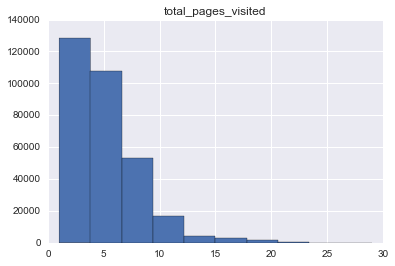

In [8]:
data.hist(column='total_pages_visited')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10de757d0>]], dtype=object)

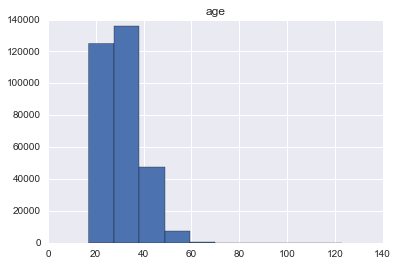

In [9]:
data.hist(column='age')

We will start with a Gradient Boosting Classifier. First, apply hot encoding for the categorical features.

In [10]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

In [11]:
# One hot encoding - join newly generated columns to the data frame
data = data.join(pd.get_dummies(data.source))
data = data.join(pd.get_dummies(data.country))
data = data.join(pd.get_dummies(data.new_user))

In [12]:
# drop one-hot encoded columns
data.drop(['country','source', 'new_user'], 1, inplace=True)

In [13]:
# fix col names
col_names = list(data.columns)
col_names[-1] = "new_user"
col_names[-2] = "returning_user"
data.columns = col_names

In [14]:
data.head()

,age,total_pages_visited,converted,Ads,Direct,Seo,China,Germany,UK,US,returning_user,new_user
0,25,1,0,1,0,0,0,0,1,0,0,1
1,23,5,0,0,0,1,0,0,0,1,0,1
2,28,4,0,0,0,1,0,0,0,1,0,1
3,39,5,0,0,0,1,1,0,0,0,0,1
4,30,6,0,0,0,1,0,0,0,1,0,1


In [15]:
# Get feature names
features = col_names
features.remove('converted')

In [16]:
# Convert df to np 2D array and divide data into training and testing sets
X = data[features].as_matrix()
y = data['converted'].as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Set the parameters
original_params = {'n_estimators': 1000, 'max_depth': 25, 'max_leaf_nodes':None, 'random_state': 2,
                   'min_samples_split': 5, 'learning_rate': 0.05}

# Train the classifier
clf = GradientBoostingClassifier(**original_params)
clf.fit(X_train, y_train)

In [ ]:
# Predict classification results on the test set
y_pred = clf.predict(X_test)

In [ ]:
output = pd.DataFrame({'test_label' : y_test,
 'test_predicted' : y_pred
  })

In [ ]:
# Compute the FPR, TPR, TNR and FNR
print "tpr: ", len(output[(output.test_label == output.test_predicted) & (output.test_label == 1)])
print "tnr: ", len(output[(output.test_label == output.test_predicted) & (output.test_label == 0)])
print "fpr: ", len(output[(output.test_label != output.test_predicted) & (output.test_label == 0)])
print "fnr: ", len(output[(output.test_label != output.test_predicted) & (output.test_label == 1)])

In [ ]:
print classification_report(y_test, y_pred)

#### ROC-AUC Curve

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Random Forests

Random forests have many advantages, such as robustness to outliers or unnecessary variables. Also, using a random forest just out of the box almost always give satisfactory results, with the default params. Before building the model, here is some feature exploration for wrong values or for insights from features.

In [ ]:
data.describe()

Age 123 is suspecious. It could be for many reasons such as data entry, etc...

Filter out all ages more than 95

In [ ]:
# Reject all rows where age is more than 95
data = data[data.age < 95]
# New distribution of 'age'
print data.age.describe()

Let's compare the conversion rate / country and see if some countries have higher conversion rate than others.

In [ ]:
# See the conversion rate / country
data_raw = pd.read_csv('conversion_data.csv')
conv_rates = data_raw.groupby(by='country').converted.mean()

In [ ]:
data_raw.head()

In [ ]:
_ = conv_rates.plot(kind='bar', title='Conversion Rate / Country')

In [ ]:
# Let's plot the total_pages_visited vs conversion_rate
data_raw = pd.read_csv('conversion_data.csv')
conv_rates = data_raw.groupby(by='total_pages_visited').converted.mean()
_ = conv_rates.plot(title='conversion rate / # of visited pages',ylim=(-.1, 1.1))

In [ ]:
data_raw = pd.read_csv('conversion_data.csv')

We can see above that the higher the total number of pages visited, the higher probability of conversion ...

In [ ]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# One hot encoding - join newly generated columns to the data frame
data_raw = data_raw.join(pd.get_dummies(data_raw.source))
data_raw = data_raw.join(pd.get_dummies(data_raw.country))
data_raw = data_raw.join(pd.get_dummies(data_raw.new_user))

In [ ]:
# drop one-hot encoded columns
data_raw.drop(['country','source', 'new_user'], 1, inplace=True)

# fix col names
col_names = list(data_raw.columns)
col_names[-1] = "new_user"
col_names[-2] = "returning_user"

data_raw.columns = col_names

In [ ]:
from sklearn.preprocessing import LabelEncoder
data_raw['source'] = LabelEncoder().fit_transform(data_raw['source'])
data_raw['country'] = LabelEncoder().fit_transform(data_raw['country'])

In [ ]:
data_raw.head()

In [ ]:
# Get feature names
col_names = list(data_raw.columns)
features = col_names
features.remove('converted')

# removed "total_pages_visited because it is NOT actionable
# features.remove('total_pages_visited')

# Convert df to np 2D array and divide data into training and testing sets
X = data_raw[features].as_matrix()
y = data_raw['converted'].as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=None, max_features=3)

In [ ]:
X

In [ ]:
# We have imbalanced data and would like to use a sample weight vector as an argument
w = sum(y_train == 0) / sum(y_train == 1)
print "Negative Class Samples / Positive Class Samples is ", w
sample_weight = np.array([w/2 if elem == 1 else 1 for elem in y_train])
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print classification_report(y_test, y_pred)

In [ ]:
output = pd.DataFrame({'test_label' : y_test,
 'test_predicted' : y_pred
  })

print "Classifier 1:"
print "tpr:  2266"
print "tnr:  100632"
print "fpr:  433"
print "fnr:  1015"
print "***********************"
print "Classifier 2: "
print "tpr: ", len(output[(output.test_label == output.test_predicted) & (output.test_label == 1)])
print "tnr: ", len(output[(output.test_label == output.test_predicted) & (output.test_label == 0)])
print "fpr: ", len(output[(output.test_label != output.test_predicted) & (output.test_label == 0)])
print "fnr: ", len(output[(output.test_label != output.test_predicted) & (output.test_label == 1)])

In [ ]:
print classification_report(y_test, y_pred)

In [ ]:
features = list(data_raw.columns)

In [ ]:
importances = clf.feature_importances_
dictionary = dict(zip(features, importances))
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
print "1st Most important feature: ", features[4]
print "2nd Most important feature: ", features[1]
print "3rd Most important feature: ", features[0]
print "4th Most important feature: ", features[2]
print "5th Most important feature: ", features[3]